In [1]:
import numpy as np
%matplotlib inline

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity
from sympy import sqrt

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
vp = np.empty(shape, dtype=np.float32)
density= np.empty(shape, dtype=np.float32)
vp[:, :51] = 1.5
vp[:, 51:] = 2.5

alpha=0.31
beta=0.25

density[:, :51] = 1.
density[:, 51:] =alpha*(vp[:, 51:]**beta)

vp[:, :51] = 2.5
vp[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=vp, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbpml=10)

#plot_velocity(model)

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s


In [3]:
print(model.grid.extent)

(1200.0, 1200.0)


In [4]:
from devito import Grid , TimeFunction , Function , SparseTimeFunction
g = Grid ( shape =shape , origin =origin , extent =( (shape[0]-1)*spacing[0] ,(shape[1]-1)*spacing[1]) )
u = TimeFunction ( name =" u", grid =g , space_order =2 , time_order =2) # Wavefield
m = Function ( name =" m", grid =g) # Physical parameter
rho = Function ( name =" rho", grid =g, space_order=2) # Physical parameter
inv_rho=Function ( name =" inv_rho", grid =g, space_order =2) # Physical parameter
m.data[:]=1/(vp*vp)
inv_rho.data[:]=1/np.sqrt(density)
rho.data[:]=np.sqrt(density)
#rho.data[:]=density

#q = SparseTimeFunction ( name =" q", grid =g , coordinates = coordinates ) # Source

In [5]:
#pde = sqrt(rho)*(1/sqrt(rho)).laplace
pde = rho*inv_rho.laplace
pde

(Derivative( inv_rho(x, y), (x, 2)) + Derivative( inv_rho(x, y), (y, 2)))* rho(x, y)

In [6]:
from devito import Eq, solve,Operator
stencil = Eq(rho, pde)
stencil
op1=Operator([stencil])
print(op1)
op1()

Operator `Kernel` run in 0.01 s


#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(struct dataobj *restrict  inv_rho_vec, struct dataobj *restrict  rho_vec, const float h_x, const float h_y, struct profiler * timers, const int x_M, const int x_m, const int y_M, const int y_m)
{
  float (*restrict  inv_rho)[inv_rho_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[inv_rho_vec->size[1]])  inv_rho_vec->data;
  float (*restrict  rho)[rho_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[rho_vec->size[1]])  rho_vec->data;
  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
  _MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);
  struct timeval start_section0, end_section0;
  gettimeofday(&star

In [7]:
print(g.extent)

(1000.0, 1000.0)


In [8]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)
print(time_range)
print(model.domain_size)

TimeAxis: start=0, stop=1001.28, step=1.68, num=597
(1000.0, 1000.0)


[[500.  20.]]


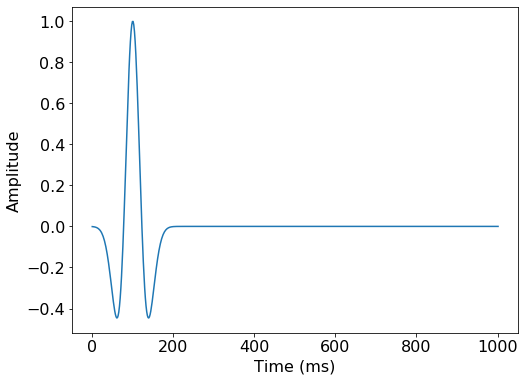

(1000.0, 1000.0)


In [9]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=g, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m
print(src.coordinates.data)
# We can plot the time signature to see the wavelet
src.show()
print(src.grid.extent)

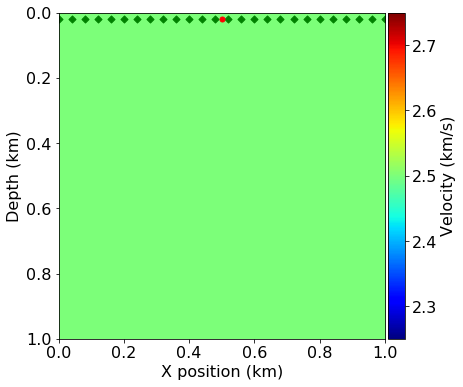

In [10]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=g, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

In [11]:
pde1 = m*u.dt2 - u.laplace
#new_wavefield=Eq(u, u*inv_rho)
pde2=m*u.dt2 -u.laplace+rho*u
#pde=m*u.dt2 - u.laplace + sqrt(rho)*(1/sqrt(rho)).laplace*u
#pde=m*(u).dt2 -u.laplace
pde2

 m(x, y)*Derivative( u(t, x, y), (t, 2)) +  rho(x, y)* u(t, x, y) - Derivative( u(t, x, y), (x, 2)) - Derivative( u(t, x, y), (y, 2))

In [12]:
stencil1 = Eq(u.forward, solve(pde1, u.forward))
stencil2 = Eq(u.forward, solve(pde2, u.forward))
#stencil

In [13]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / m)
# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [14]:
#op = Operator([new_wavefield]+[stencil] + src_term + rec_term)
op1 = Operator([stencil1] + src_term + rec_term)
op2 = Operator([stencil2] + src_term + rec_term)


#op = Operator(src_term + rec_term)

print(op2)
op2.arguments()

#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict  m_vec, struct dataobj *restrict  rho_vec, struct dataobj *restrict  u_vec, const float dt, const float h_x, const float h_y, const float o_x, const float o_y, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int p_rec_M, const int p_rec_m, const int p_src_M, const int p_src_m, const int time_M, const int time_m, struct profiler * timers)
{
  float (*restrict  m)[m_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[m_vec->size[1]])  

{' m': <cparam 'P' (0x7fa1805e0bf0)>,
 'x_m': 0,
 'x_size': 101,
 'x_M': 100,
 'y_m': 0,
 'y_size': 101,
 'y_M': 100,
 ' rho': <cparam 'P' (0x7fa180a35970)>,
 ' u': <cparam 'P' (0x7fa17debbbf0)>,
 'time_m': 1,
 't_size': 3,
 'dt': 0.0,
 'h_x': 10.0,
 'h_y': 10.0,
 'o_x': 0.0,
 'o_y': 0.0,
 'rec': <cparam 'P' (0x7fa17b6589f0)>,
 'time_size': 597,
 'time_M': 595,
 'p_rec_m': 0,
 'p_rec_size': 101,
 'p_rec_M': 100,
 'rec_coords': <cparam 'P' (0x7fa17c702e70)>,
 'd_m': 0,
 'd_size': 2,
 'd_M': 1,
 'src': <cparam 'P' (0x7fa17d895770)>,
 'p_src_m': 0,
 'p_src_size': 1,
 'p_src_M': 0,
 'src_coords': <cparam 'P' (0x7fa17dec3af0)>,
 'timers': <cparam 'P' (0x7fa17dfb1890)>}

In [15]:
#NBVAL_IGNORE_OUTPUT
op2(time=time_range.num-1, dt=dt)

Operator `Kernel` run in 0.02 s


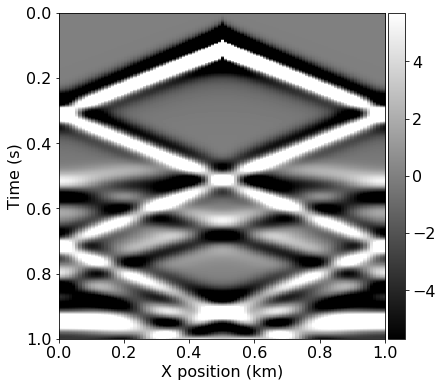

In [16]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

Operator `Kernel` run in 0.03 s


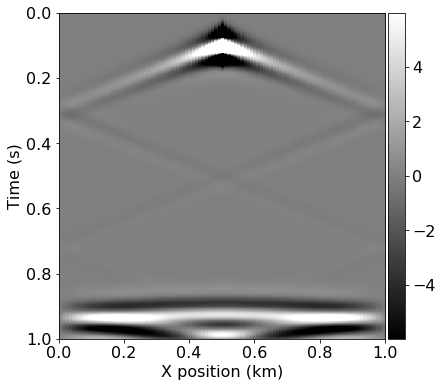

In [17]:
rec.data[:]=0.
u.data[:]=0.
op1(time=time_range.num-1, dt=dt,rec=rec)
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)